In [1]:
import sys
sys.path.insert(0, '..')

from python.kkvhash import kkv_hash

In [2]:
test = (0, 1000000, "key") # start <, end ), base word
test_start, test_end, test_base = test

hashes = []
for i in range(test_start, test_end):
    hashes.append(kkv_hash(f"{test_base}{i}".encode()))

In [3]:
import statistics as st

import matplotlib
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]

from typing import (
    List,
    Tuple,
)


class Messages:
    NO_RESULTS = "Cannot calculate the results"

class KeyArrangement(object):

    MIN_PARTITIONS_COUNT = 2**1
    MAX_PARTITIONS_COUNT = 2**6

    MIN_SLOTS_COUNT = 2**2
    MAX_SLOTS_COUNT = 2**5

    def __init__(self, hashes: List[int]) -> None:
        self._hashes = hashes
        self._size = len(self._hashes)
        self._partitions = KeyArrangement.MIN_PARTITIONS_COUNT
        self._slots = KeyArrangement.MIN_SLOTS_COUNT

        self._results: List[int] = None

    def __len__(self) -> int:
        return self._size

    @property
    def size(self) -> int:
        return self._size

    @property
    def partitions(self) -> int:
        return self._partitions

    @partitions.setter
    def partitions(self, n: int) -> None:
        self._results = None
        if n > self.MAX_PARTITIONS_COUNT:
            self._partitions = self.MAX_PARTITIONS_COUNT
        elif n < self.MIN_PARTITIONS_COUNT:
            self._partitions = self.MIN_PARTITIONS_COUNT
        else:
            self._partitions = n

    @property
    def slots(self) -> int:
        return self._slots

    @slots.setter
    def slots(self, n: int) -> None:
        self._results = None
        if n > self.MAX_SLOTS_COUNT:
            self._slots = self.MAX_SLOTS_COUNT
        elif n < self.MIN_SLOTS_COUNT:
            self._slots = self.MIN_SLOTS_COUNT
        else:
            self._slots = n

    def calc_results(self) -> None:
        divisor = self.partitions * self.slots
        
        self._results = [0]*divisor
        for hash in self._hashes:
            self._results[hash % divisor] += 1

    def _valid_results(self) -> bool:
        return self._results is not None and len(self._results)

    def get_avg(self) -> float:
        if not self._valid_results():
            return 0
        return st.mean(self._results)

    def get_stdev(self) -> float:
        if not self._valid_results():
            return 0
        return st.stdev(self._results)

    def get_pstdev(self) -> float:
        if not self._valid_results():
            return 0
        return st.pstdev(self._results)

    def get_details(self) -> Tuple[int, int, float]:
        if not self._valid_results():
            self.calc_results()

        if not self._valid_results():
            return (0, .0, .0)
    
        return (
            self.partitions,
            self.slots,
            self.get_pstdev() / self.get_avg(),
        )
    
    def print_details(self) -> None:
        if not self._valid_results():
            self.calc_results()

        if not self._valid_results():
            print(Messages.NO_RESULTS)
            return

        avg = self.get_avg()
        stdev = self.get_pstdev()
        cof = stdev / avg

        print(
            f"Partitions: {self.partitions}",
            f"Slots: {self.slots}",
            f"Avarage per slot: {avg:.2f}",
            f"Standard deviation: {stdev:.2f}",
            f"Coefficient of distribution: {cof:.4f}",
            sep='\n',
        )

    def show(self, details: bool = False) -> None:
        self.calc_results()

        if not self._valid_results():
            print(Messages.NO_RESULTS)

        if details:
            self.print_details()

        plt.rcParams['figure.figsize'] = [16, (self.slots**0.3)*self.slots]
        fig, ax = plt.subplots()

        labels = [f"P{i+1}" for i in range(self.partitions)]
        margins = [0]*self.partitions

        partitions_result = tuple(
            self._results[i*self.slots:i*self.slots+self.slots]
            for i
            in range(self.partitions)
        )
        slots_result = tuple(zip(*partitions_result))

        for i, slots_data in enumerate(slots_result):
            slot_row = ax.bar(labels, slots_data, width=0.6, label=i+1, bottom=margins)
            for index, rect in enumerate(slot_row):
                ax.text(
                    rect.get_x() + rect.get_width()/2.,
                    slots_data[index]/2 + margins[index],
                    f"{slots_data[index]}",
                    ha='center',
                    va='center'
                )

            margins = list(map(lambda x, y: x + y, margins, slots_result[i]))

        ax.set_xlabel('Partition')
        ax.set_ylabel('Capacity')
        ax.legend(title='Slot')
        plt.title(f"Key arrangement for partitions ({self.partitions}) and slots ({self.slots})")

        plt.show()

In [4]:
import itertools

test_partitions_count = [
    i for
    i in
    range(
        KeyArrangement.MIN_PARTITIONS_COUNT,
        KeyArrangement.MAX_PARTITIONS_COUNT,
        2,
    )
]

test_slots_count = [
    i for
    i in
    range(
        KeyArrangement.MIN_SLOTS_COUNT,
        KeyArrangement.MAX_SLOTS_COUNT,
        2,
    )
]

test_cases = list(itertools.product(test_partitions_count, test_slots_count))

arrangementKeyTest = KeyArrangement(hashes)


test_results = []
for config in test_cases:
    arrangementKeyTest.partitions, arrangementKeyTest.slots = config
    test_results.append(arrangementKeyTest.get_details())
    
best_one = min(test_results, key=lambda x: x[2])

del test_cases, test_results

print(f"The best config: {best_one}")

The best config: (2, 6, 0.0022995547395093688)


Partitions: 4
Slots: 4
Avarage per slot: 62500.00
Standard deviation: 686.17
Coefficient of distribution: 0.0110


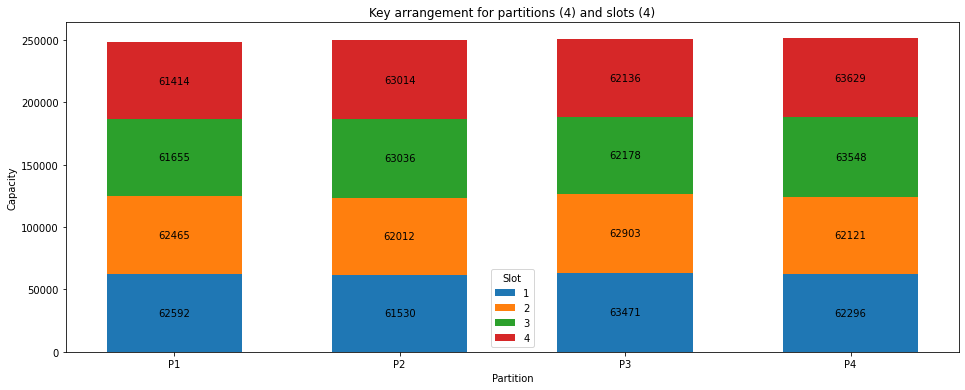

Partitions: 4
Slots: 8
Avarage per slot: 31250.00
Standard deviation: 371.84
Coefficient of distribution: 0.0119


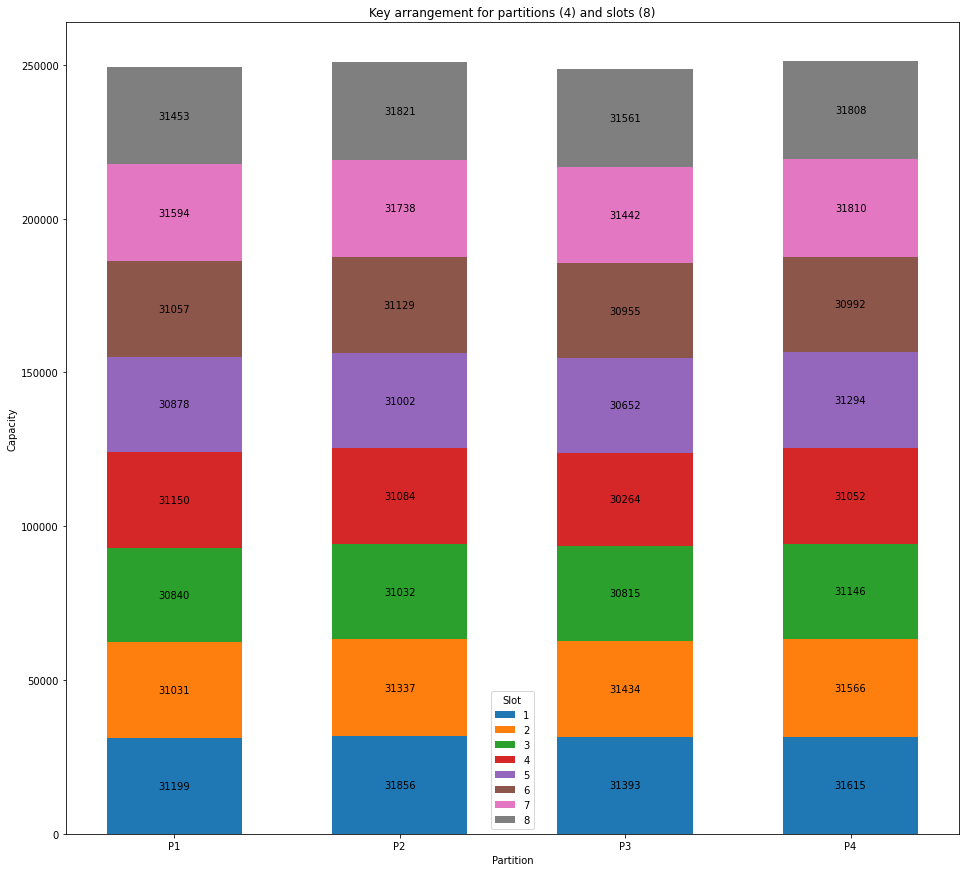

In [5]:
arrangementKeyTest.partitions, arrangementKeyTest.slots = (4, 4)
arrangementKeyTest.print_details()
arrangementKeyTest.show()

arrangementKeyTest.partitions, arrangementKeyTest.slots = (4, 8)
arrangementKeyTest.show(details=True)

# arrangementKeyTest.partitions, arrangementKeyTest.slots = (8, 16)
# arrangementKeyTest.show(details=True)

# arrangementKeyTest.partitions, arrangementKeyTest.slots = (16, 32)
# arrangementKeyTest.show(details=True)

In [7]:
# Random keys

from random import randint

buffer = [bytes([i]) for i in range(256)]

min_len_random_key = 6
max_len_random_key = 12

number_of_random_keys = 1000000

def get_rand() -> bytes:
    return buffer[randint(0, 255)]

def get_random_hashes() -> list:
    return [
        kkv_hash(b''.join([
            get_rand()
            for _
            in range(randint(min_len_random_key, max_len_random_key))
        ]))
        for i
        in range(number_of_random_keys)
    ]

arrangementRandomKey = KeyArrangement(get_random_hashes())

Partitions: 4
Slots: 4
Avarage per slot: 62500.00
Standard deviation: 234.55
Coefficient of distribution: 0.0038


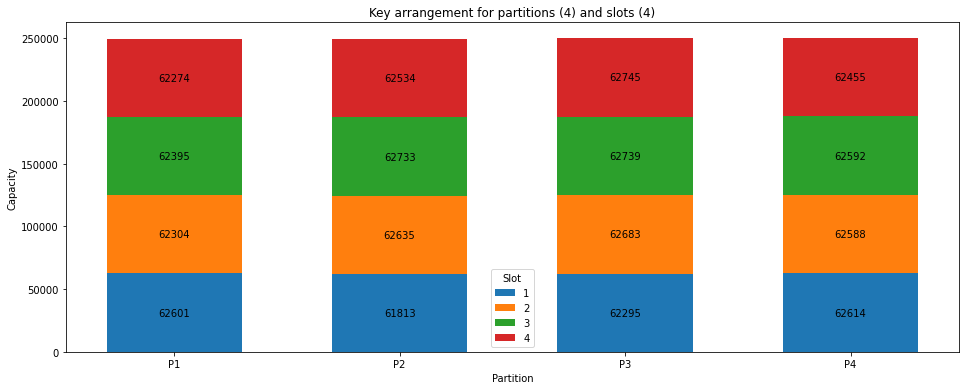

In [8]:
arrangementRandomKey.partitions, arrangementRandomKey.slots = (4, 4)
arrangementRandomKey.print_details()
arrangementRandomKey.show()